### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# To play audio files
import IPython.display as ipd
from IPython.display import Audio

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from pathlib import Path
import random
import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import torch  
print ("Done")

Done


### Process TESS data

In [2]:
Tess = "./data/TESS/tess/tess/"

'''
# Dowload TESS data from Kaggel with the code below:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path)

'''

'\n# Dowload TESS data from Kaggel with the code below:\nimport kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")\n\nprint("Path to dataset files:", path)\n\n'

In [3]:
LABEL_DICT = {0:'fear', 1:'neutral', 2:'happy',3:'angry', 4:'disgust', 5:'surprise',6:'sad'}
LABELS = list(LABEL_DICT.values())

In [4]:
LABELS

['fear', 'neutral', 'happy', 'angry', 'disgust', 'surprise', 'sad']

In [5]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess +'/' +dir) # data/TESS_D/OAF_Fear
    for file in directories:  # OAF_page_fear.wav
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
print(Tess_df.Emotions.value_counts())

reverse_label_dict = {v: k for k, v in LABEL_DICT.items()}
Tess_df['Emotions'] = Tess_df['Emotions'].map(reverse_label_dict)


Tess_df.head()



Emotions
neutral     400
angry       400
disgust     400
surprise    400
happy       400
fear        400
sad         400
Name: count, dtype: int64


,Emotions,Path
0,1,./data/TESS/tess/tess/YAF_neutral/YAF_hate_neu...
1,1,./data/TESS/tess/tess/YAF_neutral/YAF_chat_neu...
2,1,./data/TESS/tess/tess/YAF_neutral/YAF_lid_neut...
3,1,./data/TESS/tess/tess/YAF_neutral/YAF_seize_ne...
4,1,./data/TESS/tess/tess/YAF_neutral/YAF_beg_neut...


In [6]:
def get_log_melspec(data, sample_rate):
  """
  Function for extracting features from an audio sample.  The audio is preprocess to remove silence and then
  padded on both sides to ensure each clip is 5 seconds.
  Then the log mel spectrogram is extracted.
  """
  trimmed, _ = librosa.effects.trim(data, top_db=55)
  padded = np.pad(trimmed, (int(sample_rate*2-len(trimmed)//2), int(sample_rate*2-len(trimmed)//2)), 'constant')
  mel = librosa.feature.melspectrogram(y=padded, sr=sample_rate, n_fft=1024, win_length=512, hop_length=512, n_mels=128)
  return librosa.power_to_db(mel, ref=np.max)

In [7]:

# extract features and save to dataframe
def load_melspec(row):
  a, sr = librosa.load(row['Path'], sr=16000)
  return get_log_melspec(a, sr) # Seham check here 

Tess_df['logMel'] = Tess_df.apply(load_melspec, axis=1)


In [8]:
failed_files = Tess_df[Tess_df['logMel'].isnull()]
print(f"Number of failed files: {len(failed_files)}")

Number of failed files: 0


In [9]:
Tess_df.head()

,Emotions,Path,logMel
0,1,./data/TESS/tess/tess/YAF_neutral/YAF_hate_neu...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
1,1,./data/TESS/tess/tess/YAF_neutral/YAF_chat_neu...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
2,1,./data/TESS/tess/tess/YAF_neutral/YAF_lid_neut...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
3,1,./data/TESS/tess/tess/YAF_neutral/YAF_seize_ne...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
4,1,./data/TESS/tess/tess/YAF_neutral/YAF_beg_neut...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."


In [10]:
Tess_df.to_pickle('TESS_df.pkl')

### Split the Data

In [11]:
from sklearn.model_selection import train_test_split
X= Tess_df.iloc[:, 1:].values
Y = Tess_df['Emotions'].values
x_train_v, x_test, y_train_v, y_test = train_test_split(X, Y, random_state=42,test_size=0.1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=42,test_size=0.1, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((2520, 2), (2520,), (280, 2), (280,), (280, 2), (280,))

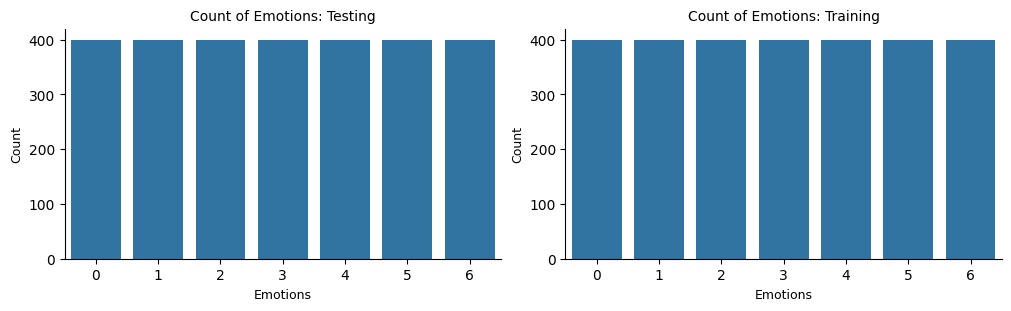

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True) 

# Plot for Testing Data
axes[0].set_title('Count of Emotions: Testing', size=10)
sns.countplot(x=Tess_df.Emotions, ax=axes[0])
axes[0].set_ylabel('Count', size=9)
axes[0].set_xlabel('Emotions', size=9)
sns.despine(ax=axes[0], top=True, right=True, left=False, bottom=False)

# Plot for Training Data
axes[1].set_title('Count of Emotions: Training', size=10)
sns.countplot(x=Tess_df.Emotions, ax=axes[1])
axes[1].set_ylabel('Count', size=9)
axes[1].set_xlabel('Emotions', size=9)
sns.despine(ax=axes[1], top=True, right=True, left=False, bottom=False)

plt.show()

In [13]:
audio_sample = Tess_df[Tess_df.Emotions == 4].sample(1, random_state=0).iloc[0]
audio_sample

Emotions                                                    4
Path        ./data/TESS/tess/tess/YAF_disgust/YAF_pass_dis...
logMel      [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
Name: 532, dtype: object

In [14]:
Audio(audio_sample['Path'])

### DataLoader

In [15]:
class getdata(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (list of tuples): Each element is a tuple (file_path, spectrogram_array).
            labels (list): List of integer labels corresponding to the data.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the spectrogram and label
        _, spectrogram = self.data[idx]
        label = self.labels[idx]

        # Convert to torch tensor and add channel dimension
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)

        # Apply any transformation
        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram, label

In [16]:
ds_train = getdata(x_train, y_train)
ds_test = getdata(x_test, y_test)
ds_val = getdata(x_val, y_val)

In [17]:
dl_train = DataLoader(ds_train, batch_size=2, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=2, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=2, shuffle=True)

## ResNet

In [18]:
import math

def set_parameter_requires_grad(model, feature_extracting, trainable_layers):
    if feature_extracting:
        for name, param in model.named_parameters():
            print(name)
            if name not in trainable_layers:
                param.requires_grad = False

class ResNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.shortcut = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False) if in_ch != out_ch else None

        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut:
            identity = self.shortcut(identity)
        out += identity
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, class_num):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.layer1 = ResNetBlock(32, 64, stride=1)
        self.layer2 = ResNetBlock(64, 128, stride=2)

        # Increased dropout rate
        self.dropout = nn.Dropout(0.50)
        self.fc = nn.Linear(128, class_num)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        x = self.layer1(x)
        x = self.layer2(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)


In [19]:
def load_resnet18_audio():
  model = ResNet(len(LABELS))

  return model

In [20]:
def set_seed(seed):
    """
    Sets random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluates the model on a given dataloader.
    """
    model.eval()  # Set model to evaluation mode
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


def train_model(model, dl_train, dl_val, criterion, optimizer, scheduler, device, num_epochs=10, checkpoint_dir='checkpoint', save_best=True):
    """
    Trains the model with checkpointing and validation.
    """
    model.to(device)
    best_val_loss = float('inf')

    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")

        # Training phase
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in tqdm(dl_train, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimization step

            # Track training loss and accuracy
            running_train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_train_loss / len(dl_train)
        train_accuracy = correct_train / total_train

        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, dl_val, criterion, device)

        # Step the learning rate scheduler
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()

        # Print epoch results
        print(f"\tTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"\tValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Save best model
        if save_best and val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(checkpoint_dir, 'best_model_tess.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with validation loss: {val_loss:.4f}")

    # Load the best model (if saved)
    if save_best:
        best_model_path = os.path.join(checkpoint_dir, 'best_model_tess.pth')
        model.load_state_dict(torch.load(best_model_path))

    return model, best_val_loss, val_accuracy


In [21]:
x= np.array(x_train[:,[1]])
d= np.array([[np.array([[1,2,3]])],[np.array([[1,2,3]])]])

In [22]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
lr = 0.0005

checkpoint_dir = 'checkpoint/'
os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure directory exists
checkpoint_path = os.path.join(checkpoint_dir, 'best_model_tess.pth')

In [23]:
# Multi-run training and evaluation
n_runs = 1
n_epochs = 10
best_val_loss = float('inf')  # Initialize as infinity for comparison

# Loop through runs
for run in range(n_runs):
    run_seed = 42 + run  # Seed varies for each run
    set_seed(run_seed)  # Ensure reproducibility for each run

    print(f"Run {run+1}/{n_runs}")
    print("=" * 30)

    # Initialize model and optimizer
    model = load_resnet18_audio().to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=0.001,  # Regularization already in use
        amsgrad=True
    )

    # Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.4, patience=4
    )
    # Train and validate
    model, val_loss, val_acc = train_model(
        model, dl_train, dl_val, criterion, optimizer, scheduler, device, num_epochs=n_epochs
    )

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"New best model found in Run {run+1} with validation loss: {val_loss:.4f}")
        torch.save(model.state_dict(), checkpoint_path)

    print()  # Blank line for better readability between runs

# Load the best model after all runs
print("Loading the best model for final evaluation...")
model = load_resnet18_audio()
try:
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)

    # Evaluate on validation data
    val_loss, val_acc = evaluate_model(model, dl_val, criterion, device=device)
    print(f"Training complete! Best Val Loss = {best_val_loss:.4f}, Best Val Accuracy = {val_acc:.4f}")
except FileNotFoundError:
    print("Error: Best model checkpoint not found. Ensure training was successful.")

print("-" * 30)

Run 1/1
Epoch [1/10]


	Train Loss: 1.3893, Train Accuracy: 0.4853
	Validation Loss: 0.7881, Validation Accuracy: 0.7071
Best model saved with validation loss: 0.7881
Epoch [2/10]


	Train Loss: 0.6934, Train Accuracy: 0.7730
	Validation Loss: 0.3363, Validation Accuracy: 0.9036
Best model saved with validation loss: 0.3363
Epoch [3/10]


	Train Loss: 0.3251, Train Accuracy: 0.9198
	Validation Loss: 0.0823, Validation Accuracy: 0.9893
Best model saved with validation loss: 0.0823
Epoch [4/10]


	Train Loss: 0.1657, Train Accuracy: 0.9675
	Validation Loss: 0.0451, Validation Accuracy: 0.9964
Best model saved with validation loss: 0.0451
Epoch [5/10]


	Train Loss: 0.1016, Train Accuracy: 0.9857
	Validation Loss: 0.0340, Validation Accuracy: 0.9964
Best model saved with validation loss: 0.0340
Epoch [6/10]


	Train Loss: 0.0737, Train Accuracy: 0.9913
	Validation Loss: 0.0183, Validation Accuracy: 1.0000
Best model saved with validation loss: 0.0183
Epoch [7/10]


	Train Loss: 0.0762, Train Accuracy: 0.9889
	Validation Loss: 0.0400, Validation Accuracy: 1.0000
Epoch [8/10]


	Train Loss: 0.0752, Train Accuracy: 0.9865
	Validation Loss: 0.0134, Validation Accuracy: 1.0000
Best model saved with validation loss: 0.0134
Epoch [9/10]


	Train Loss: 0.0507, Train Accuracy: 0.9921
	Validation Loss: 0.0164, Validation Accuracy: 0.9964
Epoch [10/10]


	Train Loss: 0.0334, Train Accuracy: 0.9976
	Validation Loss: 0.0402, Validation Accuracy: 0.9964
New best model found in Run 1 with validation loss: 0.0134

Loading the best model for final evaluation...
Training complete! Best Val Loss = 0.0134, Best Val Accuracy = 1.0000
------------------------------


In [24]:
# To load the best model:
model = load_resnet18_audio()
model.load_state_dict(torch.load(checkpoint_path ))
model.to('cuda')

ResNet(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): ResNetBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): ResNetBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, af

In [25]:
train_loss, train_acc = evaluate_model(model, dl_train, criterion, device)
print(f"Test Loss = {train_loss:.4f}, train Accuracy = {train_acc:.4f}")

val_loss, val_acc = evaluate_model(model, dl_val, criterion, device)
print(f"Test Loss = {val_loss:.4f}, val Accuracy = {val_acc:.4f}")

test_loss, test_acc = evaluate_model(model, dl_test, criterion, device)
print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.4f}")

Test Loss = 0.0149, train Accuracy = 0.9996
Test Loss = 0.0134, val Accuracy = 1.0000
Test Loss = 0.0134, Test Accuracy = 1.0000
